In [2]:
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

import matplotlib.pyplot as plt

import re
from collections import defaultdict
import glob

plt.rcParams['figure.figsize'] = [10, 5]
_EPOCH = 250

In [3]:
def get_list(d,e):
    expdir = '/tmp/deepncm/%s_resnet/' %(d)            
    explist = glob.glob('%s/*/%sevents.out.tfevents.*.bike' %(expdir,e))
    explist.sort()
    return explist
    
def get_results(d='cifar10',e="eval/"):
    explist = get_list(d,e)    
    rdict = dict()

    for expfile in explist:
        es = expfile.split('/')
        name = es[4]
        fname = es[-1]
        n = name.split('_')[0]
        if n == 'softmax' or n == 'onlinemean':
            lr = name.split('_')[1]
            p  = "%s0" %(n[0])
        else:
            p  = name.split('_')[1]
            lr = name.split('_')[2]

        x = EventAccumulator(path=expfile)
        x.Reload()
        
        acc = np.asarray([(s.step, s.value) for s in x.Scalars('accuracy')])
        A   = np.zeros((_EPOCH,2))
        A[0:acc.shape[0],:] = acc
        
        k = "mcmdistance"        
        if k in x.Tags()['scalars']:
            rmd = np.asarray([(s.step, s.value) for s in x.Scalars(k)])
            R   = np.zeros((_EPOCH,2))
            R[0:rmd.shape[0],:] = rmd
            
        else:
            rmd = np.zeros((1,1))
            R   = None
            
        print ("%8s | %10s | %5s | %7s | (%3d %1d) (%3d %1d) | %s" %(d,n,p,lr,acc.shape[0],acc.shape[1],rmd.shape[0],rmd.shape[1],name))
        rdict[name] = {'name':n,'par':p,'lr':float(lr[2:]),'acc':A,'rmd':R}

    return rdict

In [18]:
def get_plot_keys(rdict,m,opp):
    if isinstance(m, str):
        s = [k for k in rdict.keys() if (m in k)]
        t = m
    elif len(m) == 1:
        s = [k for k in rdict.keys() if (m[0] in k)]
        t = m[0]
    elif len(m) == 2:
        t = "%s %s %s" %(m[0],opp,m[1])
        if opp == "&":
            s = [k for k in rdict.keys() if (m[0] in k and m[1] in k)]
        else:
            s = [k for k in rdict.keys() if (m[0] in k or m[1] in k)]
    else:
        t = ""
        if opp == "&":
            s = [k for k in rdict.keys() if all([i for i in m if i in k])]
        else:
            s = [k for k in rdict.keys() if any([i for i in m if i in k])]                        
    return s,t

def plot_results(X,Y,L,tStr):
    plt.plot(X,Y,linewidth=2.0)
    plt.legend(L)
    plt.title(tStr)

def plot_results_rmd(rdict=None,m=["onlinemean"],opp="|",tStr=""):
    r,t = get_plot_keys(rdict,m,opp)
    s   = [i for i in r if not (type(rdict[i]['rmd']) == type(None))]
           
    Y = np.concatenate([rdict[i]['rmd'][:,1] for i in s]).reshape([len(s),-1]).transpose()
    X = rdict[s[0]]['rmd'][:,0]
    L = ["%3s-%s-%5.2e" %(rdict[i]['name'][0:3],rdict[i]['par'][1:],rdict[i]['lr']) for i in s]
    plot_results(X,Y,L,tStr+t)
    
def plot_results_acc(rdict=None,m=["onlinemean"],opp="|",tStr=""):
    s,t = get_plot_keys(rdict,m,opp)
            
    Y = np.concatenate([rdict[i]['acc'][:,1] for i in s]).reshape([-1,250]).transpose()
    X = np.arange(0,_EPOCH)    
    #L = ["%3s-%s-%5.2e (%5.2f)" %(rdict[i]['name'][0:3],rdict[i]['par'][1:],rdict[i]['lr'], 100*rdict[i]['acc'][:,1].max()) for i in s]
    L = ["%s (%5.2f)" %(rdict[i]['name'], 100*rdict[i]['acc'][:,1].max()) for i in s]
    plot_results(X,Y,L,tStr+t)    

In [5]:
c10dict = get_results(d='cifar10')
c100dict = get_results(d='cifar100')

 cifar10 |  decaymean |   d50 | lr1e-01 | (250 2) (  1 1) | decaymean_d50_lr1e-01
 cifar10 |  decaymean |   d50 | lr1e-02 | (250 2) (250 2) | decaymean_d50_lr1e-02
 cifar10 |  decaymean |   d75 | lr1e-01 | (250 2) (  1 1) | decaymean_d75_lr1e-01
 cifar10 |  decaymean |   d75 | lr1e-02 | (250 2) (250 2) | decaymean_d75_lr1e-02
 cifar10 |  decaymean |   d90 | lr1e-01 | (250 2) (250 2) | decaymean_d90_lr1e-01
 cifar10 |  decaymean |   d90 | lr1e-02 | (250 2) (  1 1) | decaymean_d90_lr1e-02
 cifar10 |  decaymean |   d95 | lr1e-01 | (250 2) (  1 1) | decaymean_d95_lr1e-01
 cifar10 |  decaymean |   d95 | lr1e-02 | (250 2) (  1 1) | decaymean_d95_lr1e-02
 cifar10 |    omreset | r0100 | lr1e-01 | (250 2) (  1 1) | omreset_r0100_lr1e-01
 cifar10 |    omreset | r0100 | lr1e-02 | (250 2) (  1 1) | omreset_r0100_lr1e-02
 cifar10 |    omreset | r0195 | lr1e-01 | (250 2) (  1 1) | omreset_r0195_lr1e-01
 cifar10 |    omreset | r0195 | lr1e-02 | (250 2) (  1 1) | omreset_r0195_lr1e-02
 cifar10 |    om

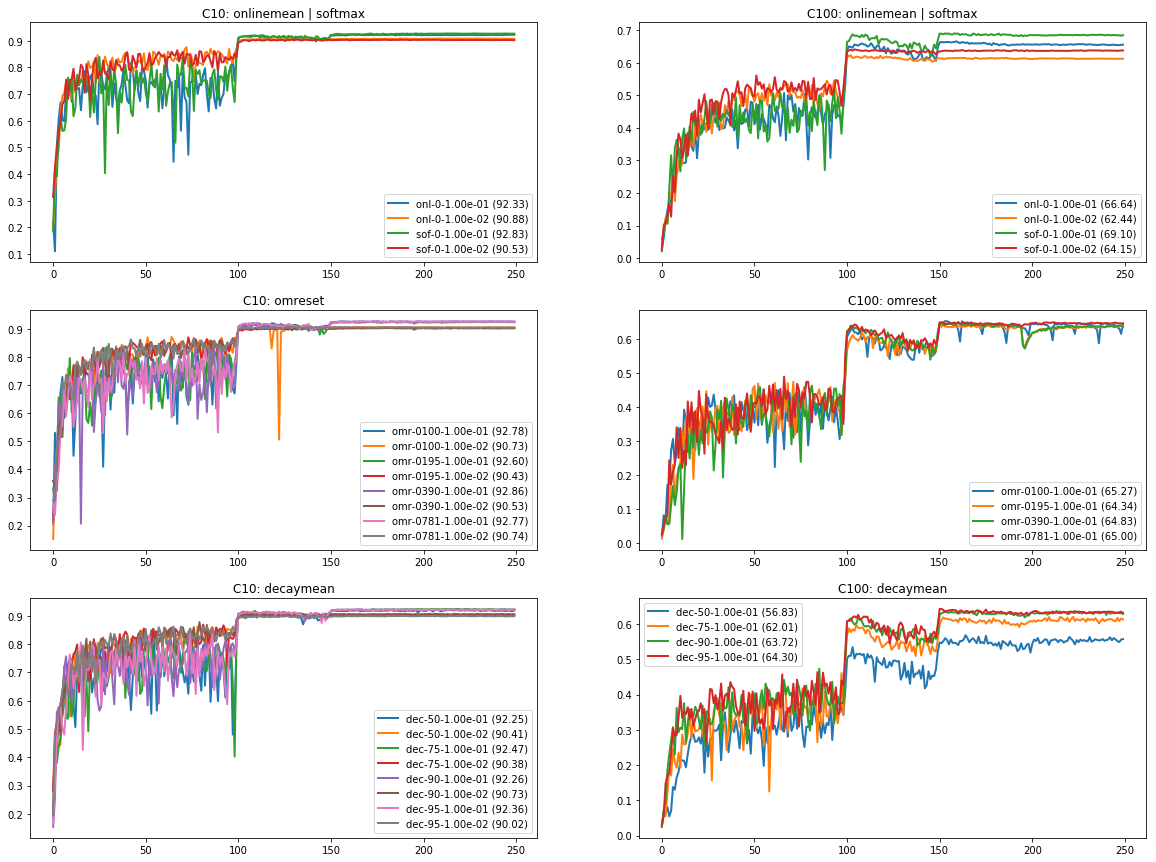

In [12]:
plt.figure(1,figsize=[20,15])
plt.subplot(321)
plot_results_acc(rdict=c10dict,m=["onlinemean","softmax"],opp="|",tStr="C10: ")
plt.subplot(323)
plot_results_acc(rdict=c10dict,m="omreset",tStr="C10: ")
plt.subplot(325)
plot_results_acc(rdict=c10dict,m="decaymean",tStr="C10: ")

plt.subplot(322)
plot_results_acc(rdict=c100dict,m=["onlinemean","softmax"],opp="|",tStr="C100: ")
plt.subplot(324)
plot_results_acc(rdict=c100dict,m="omreset",tStr="C100: ")
plt.subplot(326)
plot_results_acc(rdict=c100dict,m="decaymean",tStr="C100: ")
plt.savefig("figs/exp_cifar_overview.png",dpi=150,bbox_inches="tight",pad_inches=0.1,transparent=False,facecolor='w')
plt.show()

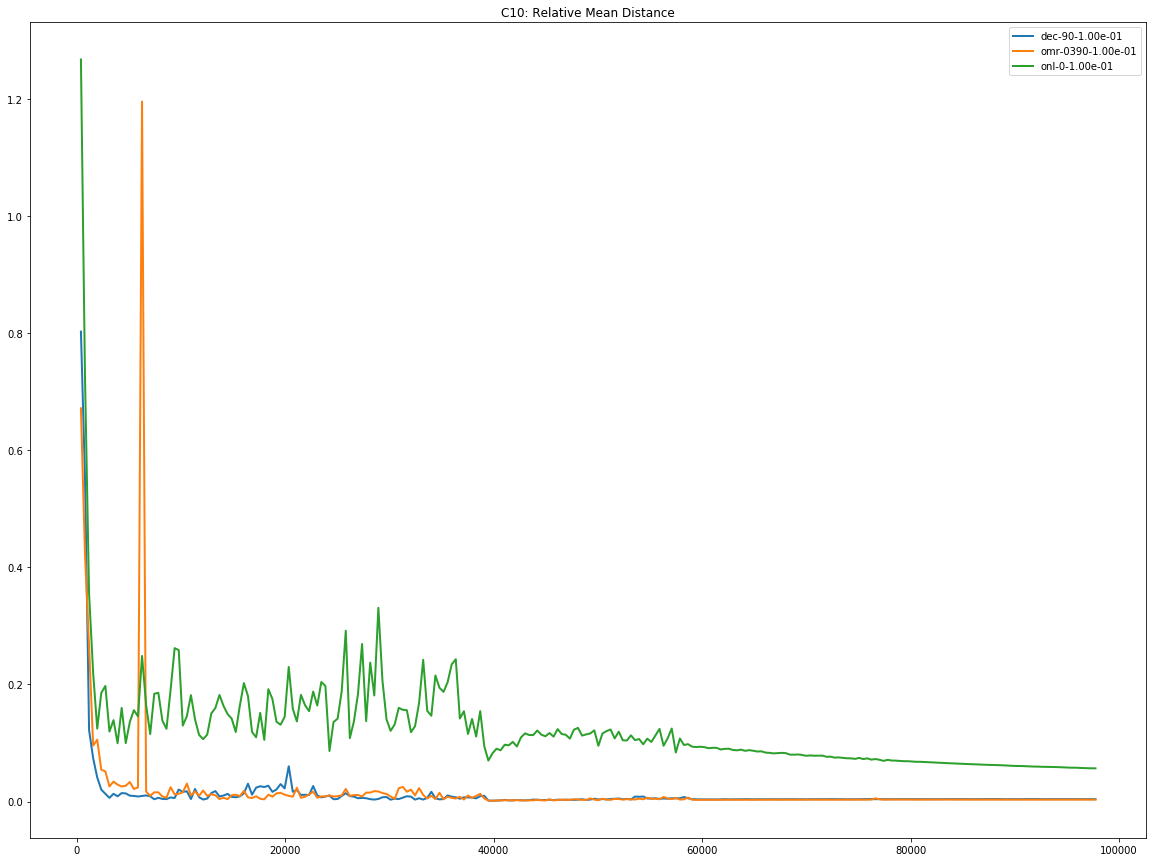

In [8]:
plt.figure(1,figsize=[20,15])
plot_results_rmd(rdict=c10dict,m=["onlinemean","omreset","decaymean_d90"],opp="|",tStr="C10: Relative Mean Distance")
plt.savefig("figs/exp_cifar10_relative_mean_distance.png",dpi=150,bbox_inches="tight",pad_inches=0.1,transparent=False,facecolor='w')
plt.show()

# Nicer figures

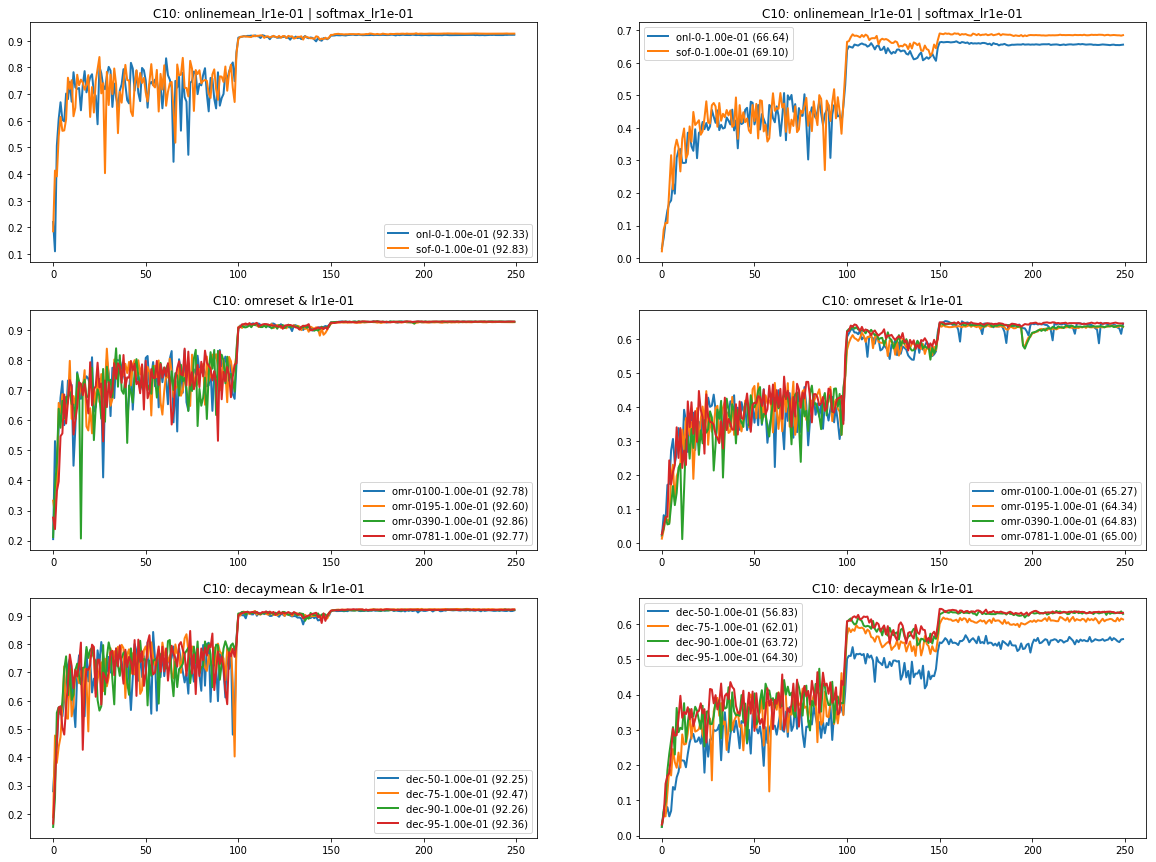

In [13]:
plt.figure(1,figsize=[20,15])
plt.subplot(321)
plot_results_acc(rdict=c10dict,m=["onlinemean_lr1e-01","softmax_lr1e-01"],opp="|",tStr="C10: ")
plt.subplot(323)
plot_results_acc(rdict=c10dict,m=["omreset","lr1e-01"],opp="&",tStr="C10: ")
plt.subplot(325)
plot_results_acc(rdict=c10dict,m=["decaymean","lr1e-01"],opp="&",tStr="C10: ")

plt.subplot(322)
plot_results_acc(rdict=c100dict,m=["onlinemean_lr1e-01","softmax_lr1e-01"],opp="|",tStr="C10: ")
plt.subplot(324)
plot_results_acc(rdict=c100dict,m=["omreset","lr1e-01"],opp="&",tStr="C10: ")
plt.subplot(326)
plot_results_acc(rdict=c100dict,m=["decaymean","lr1e-01"],opp="&",tStr="C10: ")

plt.show()

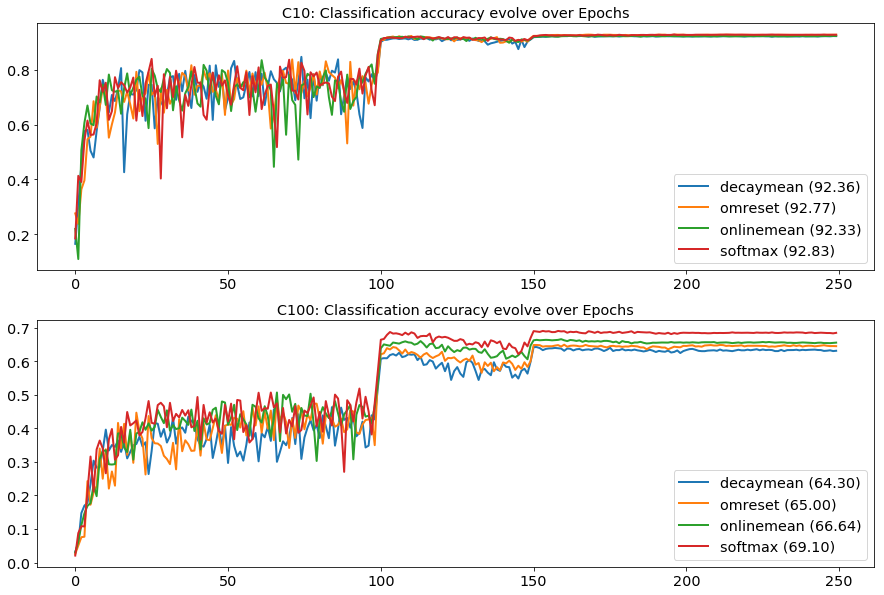

In [22]:
m = ["softmax_lr1e-01","onlinemean_lr1e-01","decaymean_d95_lr1e-01","omreset_r0781_lr1e-01"]
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(1,figsize=[15,10])
plt.subplot(211)
plot_results_acc(rdict=c10dict,m=m,opp="|",tStr="C10: Classification accuracy evolve over Epochs")
plt.subplot(212)
plot_results_acc(rdict=c100dict,m=m,opp="|",tStr="C100: Classification accuracy evolve over Epochs")
plt.savefig("figs/exp_cifar_best.pdf",dpi=250,bbox_inches="tight",pad_inches=0.1,transparent=False,facecolor='w')
plt.show()

In [ ]:
m = ["onlinemean_lr1e-01","decaymean_d90_lr1e-01","omreset_r0390_lr1e-01"]
plot_results_rmd(rdict=c10train,m=m,opp="|",tStr="C10: Relative Mean Distance ")
plt.yscale("log")

In [ ]:
a = np.zeros((3,3))
b = None
print(type(a) == type(None))
print(type(b) == type(None))